# Stock Price Prediction


## Predicting the future stock price is theoretically impossible as it depends on numerous factors which are non-deterministic such as dramatic decisions from government, new research and many more. 

## This is an optimistic approach to check the feasibility of machine learning in this field when worked with limited amount of data and resources.

### Import libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import datetime
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
mpl.rc('figure', figsize=(12, 8))
mpl.__version__

'3.0.3'

### Load data

### Data source: https://finance.yahoo.com/quote/AAPL/history?period1=1315247400&period2=1567708200&interval=1d&filter=history&frequency=1d

In [4]:
df = pd.read_csv("Data/AAPL.csv")

### Data analysis

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-09-06,52.481430,54.332859,52.354286,54.248573,47.343441,127424500
1,2011-09-07,55.080002,55.085712,54.571430,54.847141,47.865822,87644200
2,2011-09-08,54.628571,55.515713,54.615715,54.877144,47.891994,104039600
3,2011-09-09,54.847141,55.142857,53.574287,53.925713,47.061695,141203300
4,2011-09-12,53.285713,54.411430,53.128571,54.277142,47.368378,116958100


### Extract timestamp from date

In [6]:
df["Timestamp"] = df["Date"].apply(lambda x:  int(datetime.datetime.strptime(x, '%Y-%m-%d').timestamp()))

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Timestamp
0,2011-09-06,52.481430,54.332859,52.354286,54.248573,47.343441,127424500,1315247400
1,2011-09-07,55.080002,55.085712,54.571430,54.847141,47.865822,87644200,1315333800
2,2011-09-08,54.628571,55.515713,54.615715,54.877144,47.891994,104039600,1315420200
3,2011-09-09,54.847141,55.142857,53.574287,53.925713,47.061695,141203300,1315506600
4,2011-09-12,53.285713,54.411430,53.128571,54.277142,47.368378,116958100,1315765800


In [8]:
# To check that the reverse works properly
df["ReturnDate"] = df["Timestamp"].apply(lambda x:  datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))

In [9]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Timestamp,ReturnDate
0,2011-09-06,52.481430,54.332859,52.354286,54.248573,47.343441,127424500,1315247400,2011-09-06
1,2011-09-07,55.080002,55.085712,54.571430,54.847141,47.865822,87644200,1315333800,2011-09-07
2,2011-09-08,54.628571,55.515713,54.615715,54.877144,47.891994,104039600,1315420200,2011-09-08
3,2011-09-09,54.847141,55.142857,53.574287,53.925713,47.061695,141203300,1315506600,2011-09-09
4,2011-09-12,53.285713,54.411430,53.128571,54.277142,47.368378,116958100,1315765800,2011-09-12


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 9 columns):
Date          2013 non-null object
Open          2013 non-null float64
High          2013 non-null float64
Low           2013 non-null float64
Close         2013 non-null float64
Adj Close     2013 non-null float64
Volume        2013 non-null int64
Timestamp     2013 non-null int64
ReturnDate    2013 non-null object
dtypes: float64(5), int64(2), object(2)
memory usage: 141.6+ KB


In [11]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Timestamp
count,2013.000000,2013.000000,2013.000000,2013.000000,2013.000000,2.013000e+03,2.013000e+03
mean,118.999640,120.060762,117.917842,119.008466,112.659464,6.330921e+07,1.441435e+09
std,45.642890,46.059403,45.282164,45.679553,47.642381,4.886059e+07,7.289600e+07
min,52.481430,53.021427,50.605713,51.938572,45.327473,1.136200e+07,1.315247e+09
25%,81.308571,81.828575,80.175713,81.157143,71.578697,2.890680e+07,1.378406e+09
50%,109.720001,110.730003,108.660004,109.580002,103.170418,4.669910e+07,1.441305e+09
75%,155.020004,156.330002,153.779999,155.320007,151.044632,8.158780e+07,1.504550e+09
max,230.779999,233.470001,229.779999,232.070007,228.523819,3.765300e+08,1.567622e+09


### Rolling mean

In [12]:
mavg = df["Adj Close"].rolling(window=50).mean()

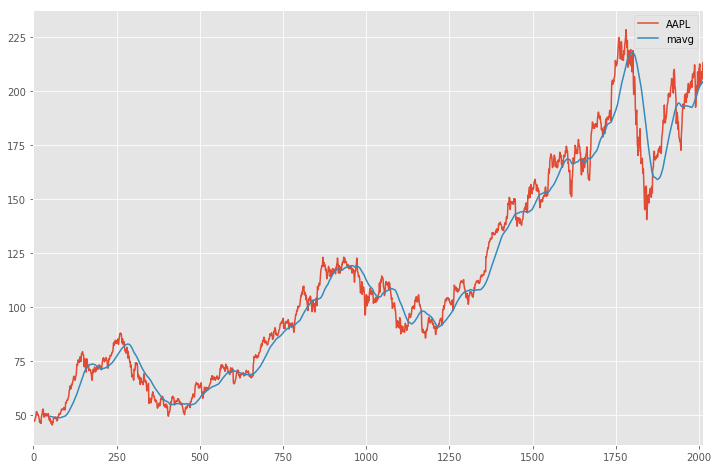

In [13]:
style.use('ggplot')
df["Adj Close"].plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

### Regression models

### We would consider only the adjusted closing price ( "Adj Close" ) as the reference

### To begin with, only the timestamp is used as the input features.

In [14]:
X = np.reshape(df["Timestamp"].values, (len(df),1))
y = df["Adj Close"]

In [15]:
X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[int(0.7*len(X)):]
y_test = y[int(0.7*len(y)):]

In [16]:
max_iter = 10000

In [17]:
svr_lin = SVR(kernel= 'linear', C= 1e3, max_iter = max_iter, verbose = True)
svr_poly = SVR(kernel= 'poly', C= 1e3, degree= 2, max_iter = max_iter, verbose = True)
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1, max_iter = max_iter, verbose = True)
svr_rbf_100 = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1, max_iter = 100, verbose = True)

In [18]:
svr_rbf.fit(X_train, y_train) 

[LibSVM]

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=10000, shrinking=True, tol=0.001, verbose=True)

In [19]:
svr_rbf_100.fit(X_train, y_train) 

[LibSVM]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=100, shrinking=True, tol=0.001, verbose=True)

In [20]:
svr_lin.fit(X_train, y_train)

[LibSVM]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=10000, shrinking=True,
  tol=0.001, verbose=True)

In [21]:
svr_poly.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
  gamma='auto_deprecated', kernel='poly', max_iter=10000, shrinking=True,
  tol=0.001, verbose=True)

In [22]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [23]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.45792e-38): result may not be accurate.
  overwrite_a=True).T


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [24]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.78358e-57): result may not be accurate.
  overwrite_a=True).T


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [25]:
def timestamp_to_date(timestamps):
    dates = []
    for i in timestamps:
        dates.append(datetime.datetime.fromtimestamp(i).strftime('%Y-%m-%d'))
    return dates

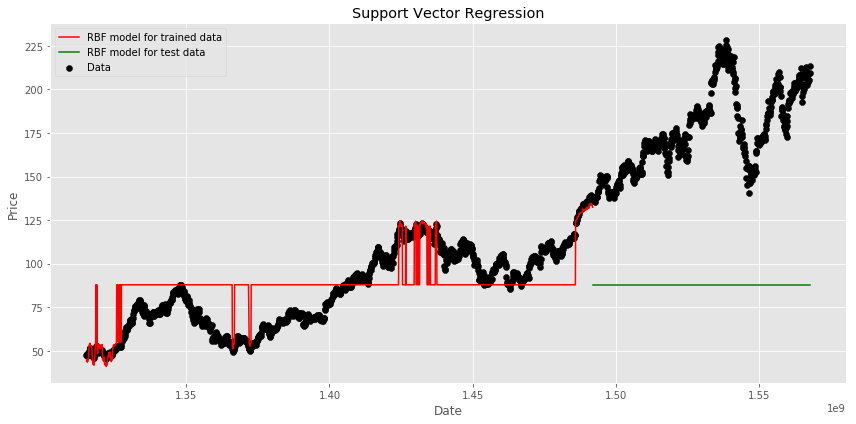

In [26]:
plt.figure(figsize=(12,6))
plt.scatter(X, y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train, svr_rbf_100.predict(X_train), color= 'red', label= 'RBF model for trained data')
plt.plot(X_test, svr_rbf_100.predict(X_test), color= 'green', label= 'RBF model for test data') 

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()

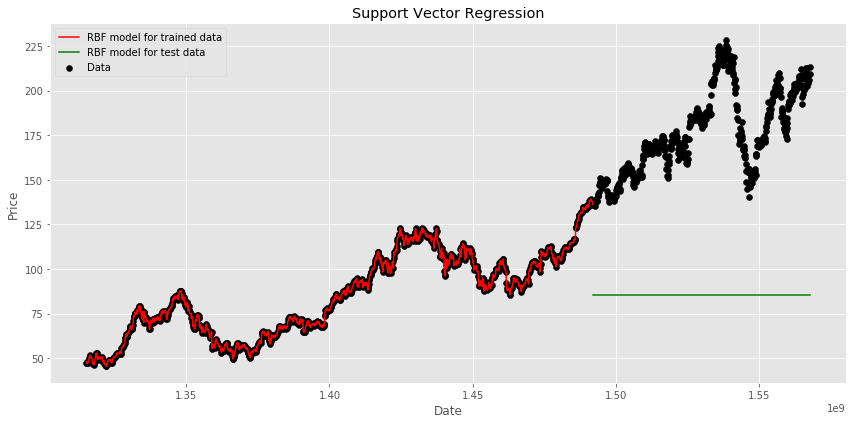

In [27]:
plt.figure(figsize=(12,6))
plt.scatter(X, y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train, svr_rbf.predict(X_train), color= 'red', label= 'RBF model for trained data')
plt.plot(X_test, svr_rbf.predict(X_test), color= 'green', label= 'RBF model for test data') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()

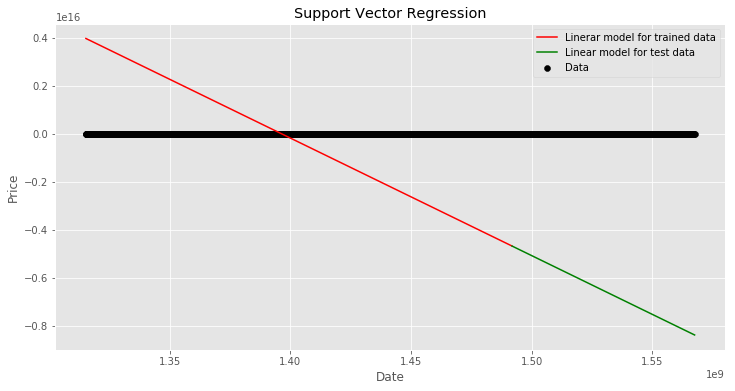

In [28]:
plt.figure(figsize=(12,6))
plt.scatter(X, y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train, svr_lin.predict(X_train), color= 'red', label= 'Linerar model for trained data') 
plt.plot(X_test, svr_lin.predict(X_test), color= 'green', label= 'Linear model for test data') 

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

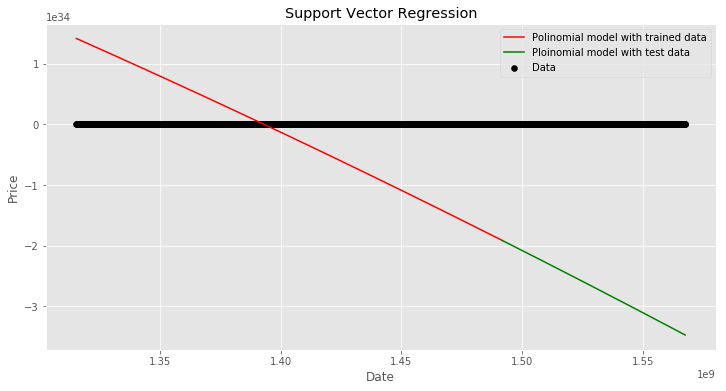

In [29]:
plt.figure(figsize=(12,6))
plt.scatter(X, y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train, svr_poly.predict(X_train), color= 'red', label= 'Polinomial model with trained data')
plt.plot(X_test, svr_poly.predict(X_test), color= 'green', label= 'Ploinomial model with test data') 

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

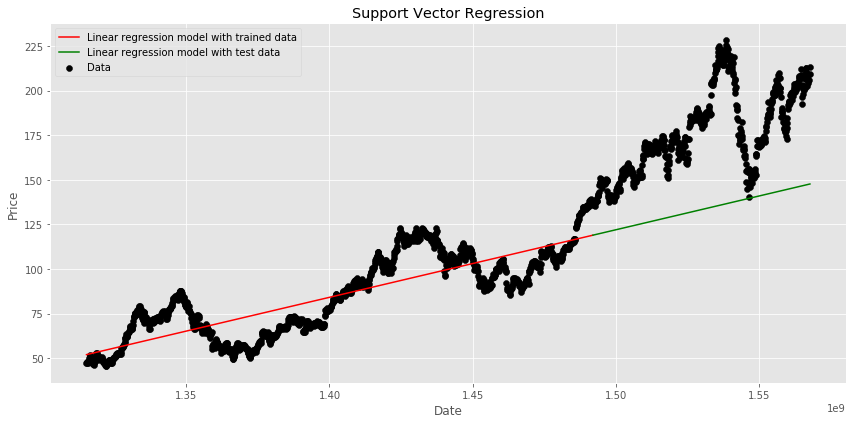

In [30]:
plt.figure(figsize=(12,6))
plt.scatter(X, y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train, clfreg.predict(X_train), color= 'red', label= 'Linear regression model with trained data') 
plt.plot(X_test, clfreg.predict(X_test), color= 'green', label= 'Linear regression model with test data') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()

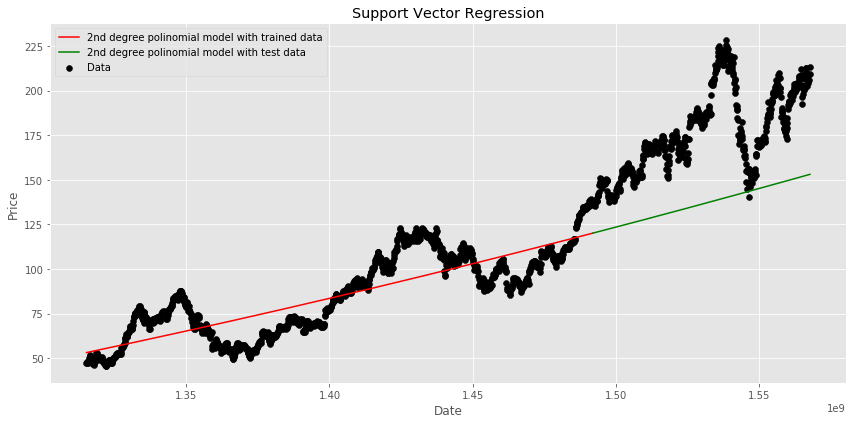

In [31]:
plt.figure(figsize=(12,6))
plt.scatter(X, y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train, clfpoly2.predict(X_train), color= 'red', label= '2nd degree polinomial model with trained data') 
plt.plot(X_test, clfpoly2.predict(X_test), color= 'green', label= '2nd degree polinomial model with test data') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()

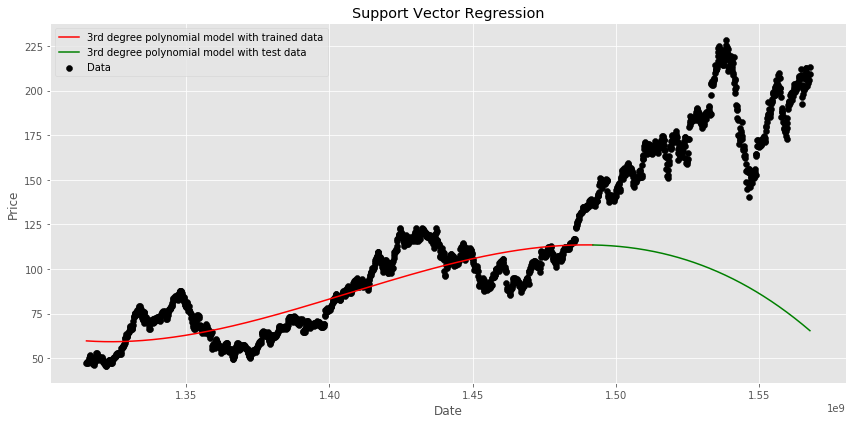

In [32]:
plt.figure(figsize=(12,6))
plt.scatter(X, y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train, clfpoly3.predict(X_train), color= 'red', label= '3rd degree polynomial model with trained data') 
plt.plot(X_test, clfpoly3.predict(X_test), color= 'green', label= '3rd degree polynomial model with test data')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()

## The above results were bad as expected.

## Now we will consider more relatable features for the input

In [33]:
X = df.drop(['Adj Close','ReturnDate','Date'], 1)
y = df["Adj Close"]


In [34]:
X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[int(0.7*len(X)):]
y_test = y[int(0.7*len(y)):]

In [35]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [36]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.52743e-38): result may not be accurate.
  overwrite_a=True).T


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [37]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.11927e-57): result may not be accurate.
  overwrite_a=True).T


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [38]:
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1, max_iter = max_iter, verbose = True)
svr_rbf.fit(X_train, y_train)

[LibSVM]

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=10000, shrinking=True, tol=0.001, verbose=True)

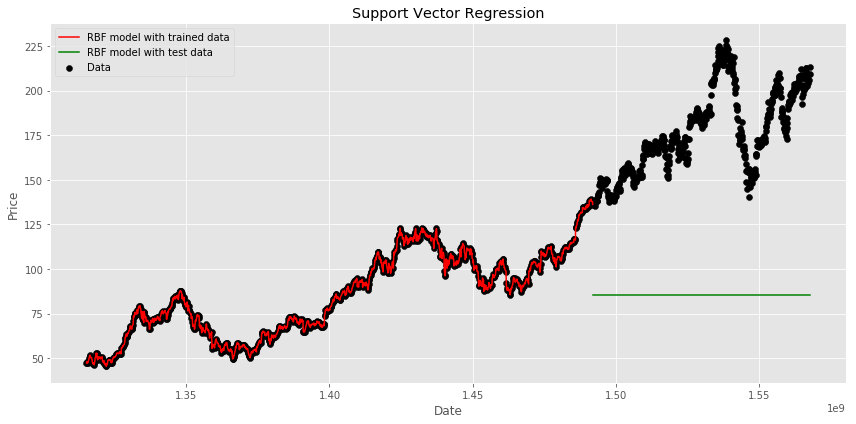

In [39]:
plt.figure(figsize=(12,6))
plt.scatter(X["Timestamp"], y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train["Timestamp"], svr_rbf.predict(X_train), color= 'red', label= 'RBF model with trained data') 
plt.plot(X_test["Timestamp"], svr_rbf.predict(X_test), color= 'green', label= 'RBF model with test data') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()

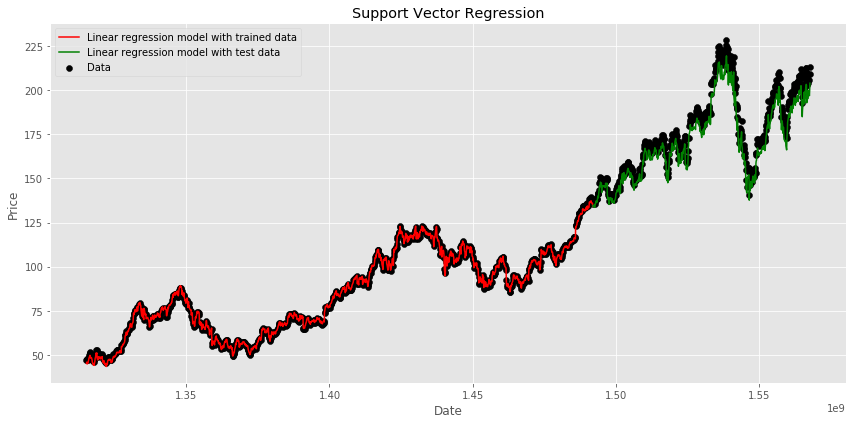

In [40]:
plt.figure(figsize=(12,6))
plt.scatter(X["Timestamp"], y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train["Timestamp"], clfreg.predict(X_train), color= 'red', label= 'Linear regression model with trained data') 
plt.plot(X_test["Timestamp"], clfreg.predict(X_test), color= 'green', label= 'Linear regression model with test data') 

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()

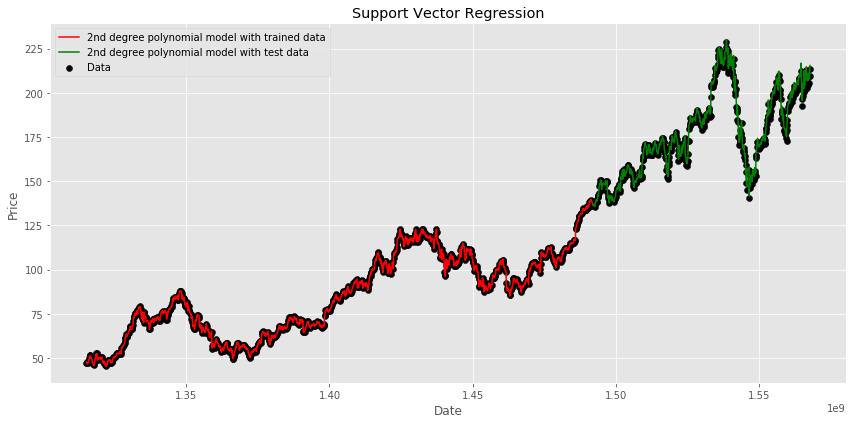

In [41]:
plt.figure(figsize=(12,6))
plt.scatter(X["Timestamp"], y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train["Timestamp"], clfpoly2.predict(X_train), color= 'red', label= '2nd degree polynomial model with trained data')
plt.plot(X_test["Timestamp"], clfpoly2.predict(X_test), color= 'green', label= '2nd degree polynomial model with test data') 

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()

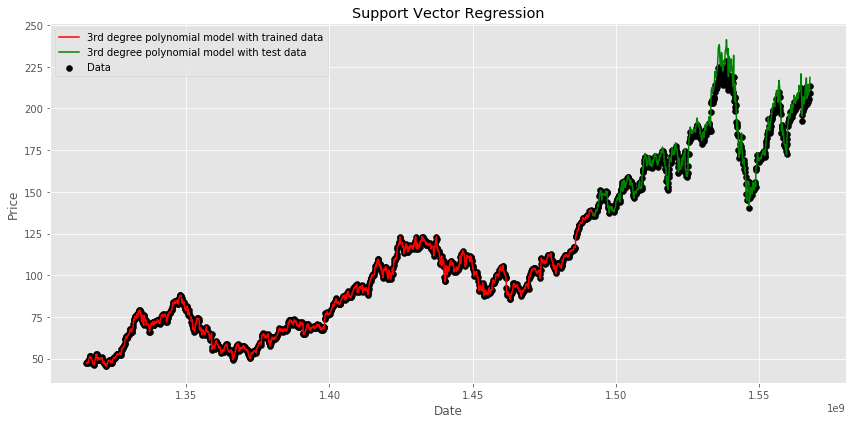

In [42]:
plt.figure(figsize=(12,6))
plt.scatter(X["Timestamp"], y, color= 'black', label= 'Data') # plotting the initial datapoints 

plt.plot(X_train["Timestamp"], clfpoly3.predict(X_train), color= 'red', label= '3rd degree polynomial model with trained data')
plt.plot(X_test["Timestamp"], clfpoly3.predict(X_test), color= 'green', label= '3rd degree polynomial model with test data') 

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.legend()
plt.tight_layout()
plt.show()